## Advanced Dimensionality Reduction: Deep Learning

#### Misael M. Morales

### Executive Summary
Subsurface spatial data is often very large and difficult to process and utilize in machine learning workflows. Moreover, there tends to be high degrees of correlation and structure in 2D subsurface data, which makes it a perfect candidate for latent structure analysis and modeling. 

Here, we will utilize a 2D multivariate subsurface dataset and demonstrate the usage of **Deep Learning** to encode the data into the latent space and then reconstruct using a fraction of the original size. 

We learn that using Deep Learning, different latent dimensions will result in different degrees of lossy reconstruction, but that this method is efficient, economic, and simple enough to treat our large data into a reduced dimensionality form. We recommend to use this autoencoder structure whenever dealing with image or volume problems in order to reduce redundancy and increase efficiency of our machine learning workflows.

### Table of Contents
1. Import Packages 
2. Declare Functions 
3. Load & Preprocess Data
        a) MNIST Data 
        b) Subsurface Data

4. Dimensionality Reduction: Deep Learning

***

### 1. Import Packages

We start by importing our most basic packages:

In [1]:
%matplotlib inline
import numpy as np                     #arrays and matrix math
import pandas as pd                    #DataFrames management and indexing
import matplotlib.pyplot as plt        #plotting and visualization
import matplotlib.gridspec as gridspec #enhanced subplot referencing
import tensorflow as tf                #deep learning functionality and MNIST data

Import other important packages for preprocessing, metrics, etc., and project-specific packages and functions

In [2]:
# Data loading
from scipy import io as sio                                 #import matlab files

# Feature Engineering/Preprocessing
from sklearn.preprocessing import StandardScaler            #Standardize variables to mean=0, var=1
from sklearn.preprocessing import MinMaxScaler              #Scale variables to min=0, max=1
from scipy.interpolate import Rbf as Rbf_interpolation      #Inteprolate 2D map from sparse data

# Training timer
from time import time                                       #timer for training

# Goodness-of-Fit Metrics
from sklearn.metrics import mean_squared_error                    #Mean squared error (MSE)
from skimage.metrics import mean_squared_error as image_mse       #Mean Squared Error for images
from skimage.metrics import structural_similarity as image_ssim   #Structural Similarity Index (SSIM)

# Project-specific
import keras
from keras import Model, regularizers
from keras.layers import Input
from keras.layers import Flatten, Reshape, ReLU, Lambda
from keras.layers import Dense, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization

### 2. Delcare Functions
The following functions will be used in the workflow.

In [3]:
# Plot function for sample images
def plot_sample_matrix(samples, my_cmap):
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig  = plt.figure(figsize=(axes, axes))
    gs   = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off'); ax.set_aspect('equal')
        plt.imshow(sample, cmap=my_cmap)

In [4]:
# Function to plot training process
def plot_loss(fit):
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.title('Training: MSE vs epochs'); plt.legend()
    plt.xlabel('Epochs'); plt.ylabel('MSE')
    plt.xticks(iterations[::epochs//10])

In [5]:
# Function to plot train/test results
def plot_results(data, title):
    labels = ['Train', 'Train Pred', 'Test', 'Test Pred']
    fig, axs = plt.subplots(4, 10, figsize=(15,5))
    for i in range(4):
        for j in range(10):
            axs[i,j].imshow(data[i][j], cmap='gray')
            axs[i,0].set_ylabel(labels[i])
            axs[i,j].set(xticklabels=[], yticks=[])
    fig.suptitle(title)

This variable will help us when inserting text boxes into our matplotlib plots

In [6]:
# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

This next function is optional, and will simply be a check that your current version of tensorflow on your Python kernel is running on a GPU and if tensorflow is built with CUDA.

In [7]:
# Check tensorflow GPU settings
import tensorflow as tf
sys_info = tf.sysconfig.get_build_info()
print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
print('# GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA: {} | cuDNN: {}".format(sys_info["cuda_version"], sys_info["cudnn_version"]))
tf.config.list_physical_devices()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 3. Load & Preprocess Data

We will deal with two different datasets, both of which need preprocessing.

(1) MNIST dataset: handwritten digits as $28x28$ images from *tensorflow* </br>
(2) Subsurface multivariate data: 2D spatial (sparse) data

### 3. a) MNIST Data

This is a set of $60,000$ images of handwritten digits $0$-$9$. We load it directly from *tensorflow* datasets ([link](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist)), and will preprocess to center and flatten as needed for our techniques.

In [8]:
# Load the Dataset and split into train/test
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data()

# Choose to work with ALL or only a few (N) MNIST images (full size is 60,000)
#N = len(x_train_all)
N = 60000
M = 10000
x_train, x_test = x_train_all[:N], x_test_all[:N]
y_train, y_test = y_train_all[:N], y_test_all[:N]

# Normalize the Images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test  = np.expand_dims(x_test/255.0, axis=-1)

# Flattent the Images
x_train_f = x_train.reshape(N, 784)
x_test_f  = x_test.reshape(M, 784)

# Save X train/test as images
train_img = x_train.squeeze()
test_img  = x_test.squeeze()

# Define the labels
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Print the shapes of the training and testing sets + check that training images are normalized
print('MNIST dataset properties:')
print('Train || Shapes: X={}, Y={} | min={}, max={}'.format(x_train.shape, y_train.shape, x_train.min(), x_train.max()))
print('Test  || Shapes: X={}, Y={} | min={}, max={}'.format(x_test.shape, y_test.shape, x_test.min(), x_test.max()))
print('Flatt || Shapes: train={}, test={}'.format(x_train_f.shape, x_test_f.shape))
print('X_img || Shapes: train={}, test={}'.format(train_img.shape, test_img.shape))

MNIST dataset properties:
Train || Shapes: X=(60000, 28, 28, 1), Y=(60000,) | min=0.0, max=1.0
Test  || Shapes: X=(10000, 28, 28, 1), Y=(10000,) | min=0.0, max=1.0
Flatt || Shapes: train=(60000, 784), test=(10000, 784)
X_img || Shapes: train=(60000, 28, 28), test=(10000, 28, 28)


For improved visualization, we will define a new colormap that uses the 10 individual digits ($0$-$9$) and implement the '*jet*' colormap.

In [9]:
# Define a colormap for the 10-class classification system
import matplotlib.cm as cm
from matplotlib.colors import Normalize

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs      = my_cmap(my_norm(y_train))

Next, we will count the number of items that is in each of the 10 digit categories, and also visualize the first few samples from the training and testing dataset.

In [10]:
# Count the number of occurrences for each digit within the training/testing datasets
digit_count = {}
for i in np.arange(len(class_names)):
    digit_count[i] = x_train[y_train==i].shape[0]
digit_count = pd.DataFrame(list(digit_count.values()), columns=['Count']).T
print('Count per Digit:')
digit_count.head()

Count per Digit:


,0,1,2,3,4,5,6,7,8,9
Count,5923,6742,5958,6131,5842,5421,5918,6265,5851,5949


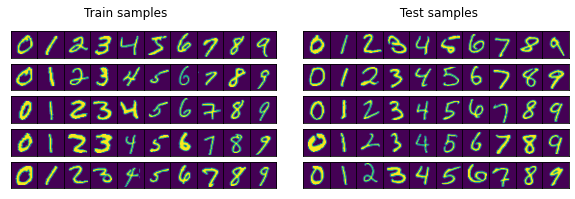

In [11]:
# Visualize a few Train/Test samples from mnist
fig = plt.figure(figsize=(10, 3), constrained_layout=False)
fig.suptitle('Train samples'+60*' '+'Test samples')
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0)

left_grid = outer_grid[0, 0].subgridspec(5, 10, wspace=0, hspace=0)
axs = left_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_train[y_train==d][c]); ax.set(xticks=[], yticks=[])
    
right_grid = outer_grid[0, 1].subgridspec(5, 10, wspace=0, hspace=0)
axs = right_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_test[y_test==d][c]); ax.set(xticks=[], yticks=[])
    
plt.show();

### 3. b) Subsurface Data

The following workflow applies the .csv file 'spatial_nonlinear_MV_facies_v1.csv', a synthetic dataset calculated with geostatistical cosimulation by Dr. Michael Pyrcz, The University of Texas at Austin. The dataset is publically available [here](https://github.com/GeostatsGuy/GeoDataSets)  

From this site, other datasets can also be used for this workflow including but not limited to: {'spatial_nonlinear_MV_facies_v5.csv', 'sample_data_MV_biased.csv', 'PGE383_Dataset_13_Wells.csv', '12_sample_data.csv'}.

We will work with the following features:

* **X** and **Y** - the sptial coordinates (in meters) for the subsurface data
* **Porosity** - fraction of rock void in units of percentage
* **Permeability** - ability of a fluid to flow through the rock in milliDarcy
* **Acoustic Impedence** - product of sonic velocity and rock density (in $kg/m^2s*10^3$)
* **Facies** - binary indicator of sand or shale facies

In [12]:
# Select a subsurface Dataset for image reconstruction
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
df.head() #visualize first few rows of the DataFrame

,X,Y,Porosity,Perm,AI,Facies
0,1.219681,10.006391,7.791849,332.802662,4114.121592,1
1,1.400597,160.265186,16.708829,505.072608,3820.596087,1
2,15.497048,775.834642,12.430224,404.367985,4180.556194,1
3,15.642437,446.832057,5.269760,196.557726,5399.358427,0
4,15.873019,476.372378,5.662789,333.942714,4055.169132,1


We perform standardization of the features by applying Standard Scaler of the features such that:

$$ x^* = \frac{x-\bar{x}}{\sigma_x} $$

such that $x^*$ has zero mean $\bar{x^*}=0.0$ and unit variance $\sigma^2_{x^*}=1.0$ for each of the features in the dataset. Otherwise, the difference between the scale of the features would have significant impact on the covariance matrix calculation.

This is done by the *scikitlearn* built-in function
``` python
standard_scaler = sklearn.preprocessing.StandardScaler()
scaled_array    = standard_scaler.fit_transform(float_array)
```

In [13]:
scaler = StandardScaler()                   #instantiate the standardization function
df_s = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)  #apply standard scaling
df_s.describe().T                           #show summary statistics of the new DataFrame

,count,mean,std,min,25%,50%,75%,max
X,457.0,6.316367e-18,1.001096,-1.841830,-0.823436,0.123333,0.853587,1.569595
Y,457.0,-3.318522e-16,1.001096,-1.822462,-0.806696,0.040559,0.892515,1.686068
Porosity,457.0,2.055249e-16,1.001096,-2.206790,-0.759814,0.049673,0.655060,2.693817
Perm,457.0,-3.512872e-16,1.001096,-1.770773,-0.657275,0.035710,0.587008,3.479338
AI,457.0,1.621849e-15,1.001096,-1.472181,-0.682380,-0.237512,0.378880,4.549487
Facies,457.0,3.187336e-16,1.001096,-1.926484,0.519080,0.519080,0.519080,0.519080


For simplicity, we specifically name our subsurface features/properties.

We also specifically name the *matplotlib* colormaps that we want to use for each of the feautures/properties.

In [14]:
features = ['Porosity','Perm','AI','Facies']       # names of our features
my_maps  = ['magma', 'jet', 'seismic', 'viridis']  # names of the corresponding colormaps

However, this is a **sparse** dataset of the subsurface, with 457 wells in approximately $1 km^2$ area of the subsurface. Therefore, we must interpolate the spatial properties so that we obtain a full image of the subsurface properties. 

The 2D interpolation is done through *scipy*'s RBF interpolation function. This generates radial basis function inteprolation from $(N,D)$ arrays to an $(M,D)$ domain.

We will interpolate the subsurface 2D data into $(28,28)$ images. These are the standard dimensions of the MNIST dataset, a generic dataset of handwritten digits that we will use later for our workflow.

In [15]:
# Interpolate spatial properties
ti = np.linspace(start=0, stop=1, num=28) #an array of 28 discrete points
XI, YI = np.meshgrid(ti,ti)               #a mesh of 28x28 discrete points
ZI = {}; ZI_s = {}                    

for i in features:
    # RBF interpolation
    ZI[i] = Rbf_interpolation(df_s['X'], df_s['Y'], df[i], function='thin_plate')(XI, YI)[::-1]
    # Normalize our interpolated features 
    ZI_s[i]  = scaler.fit_transform(ZI[i])

for i in np.arange(len(features)):
    print('Standard '+features[i]+': Shape={}, mean={:.3f}, var={:.3f}'.format(ZI_s[features[i]].shape,
                                                                               ZI_s[features[i]].mean(), 
                                                                               ZI_s[features[i]].var()))

Standard Porosity: Shape=(28, 28), mean=0.000, var=1.000
Standard Perm: Shape=(28, 28), mean=-0.000, var=1.000
Standard AI: Shape=(28, 28), mean=-0.000, var=1.000
Standard Facies: Shape=(28, 28), mean=-0.000, var=1.000


Min-Max scale features for visualization and comparison of discrete data and interpolated features

In [16]:
#Min-Max scale original features
minmax_scaler = MinMaxScaler()                           #instantiate the min_max scaler function
df_mm = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)  #apply min_max scaling

ZI_mm = {}
#Min-Max scale interpolated features
for i in features:
    ZI[i] = Rbf_interpolation(df_mm['X'], df_mm['Y'], df[i], function='thin_plate')(XI, YI)[::-1]
    ZI_mm[i] = minmax_scaler.fit_transform(ZI[i])

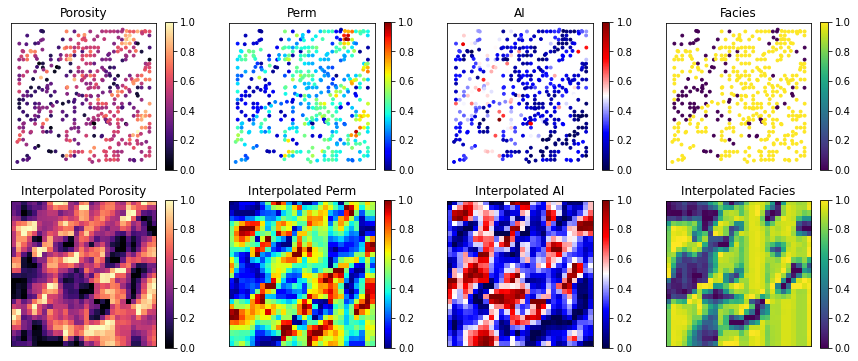

In [17]:
fig, axs = plt.subplots(2,4, figsize=(15,6))
for i in range(len(features)):
    axs[0,i].set_title(features[i]); axs[1,i].set_title('Interpolated '+features[i])
    # plot original data scatterplots
    im1 = axs[0,i].scatter(x=df_mm['X'], y=df_mm['Y'], vmin=0, vmax=1, s=8, c=df_mm[features[i]], cmap=my_maps[i])
    fig.colorbar(im1, ax=axs[0,i])
    # plot interpolated images
    im2 = axs[1,i].imshow(ZI_mm[features[i]], vmin=0, vmax=1, cmap=my_maps[i])
    fig.colorbar(im2, ax=axs[1,i])
    # remove ticks, set square box ratios
    for k in range(2):
        axs[k,i].set_xticks([]); axs[k,i].set_yticks([]); 
        axs[k,i].set_aspect('equal', adjustable='box')
plt.show();

Select one of the subsurface features to be used in the remainder of the notebook for image reconstruction.

In [18]:
# Select one of the subsruface features to work with
feature_selected = 'AI'

***

### 4. Advanced Dimensionality Reduction

Dimensionality Reduction is quite ubiqutuous in modern machine learning. PCA has been widely-studied and applied in theoretical and applied setting for data science, including reservoir characterization, modeling, and simulation. Through PCA, we can obtain an orthogonal transformation that maximally retains the variance of the features, and reduce the number of vectors to still "explain" majority of the information. With this, we can project our 2D data onto the vectors and work in latent space.

Another consideration is the idea of using the latent space for a generic dataset as the basis for reconstruction of a more complex dataset. For instance, using the PCA projection of the $60,000$ MNIST images, we can reconstruct our 2D subsurface maps from a latent represenation!

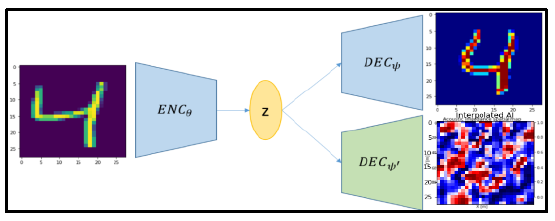

### 4. Deep Learning 
...text...

... math ...

Here, we reduce the dimension of each of the MNIST images from $784$ to $k=n_{components}$.

***

#### Fully-Connected AutoEncoder

In [19]:
keras.backend.clear_session()

inp = Input(shape=(784,))
x   = Dense(units=100, activation='relu')(inp)
enc = Dense(units=50,  activation='relu')(x)
x   = Dense(units=100, activation='relu')(enc) 
dec = Dense(units=784)(x)

fcnn_encoder = Model(inp, enc)
fcnn_model   = Model(inp, dec)
print('Number of parameters: {:,}'.format(fcnn_model.count_params()))

Number of parameters: 167,834


Training time: 7.74 minutes


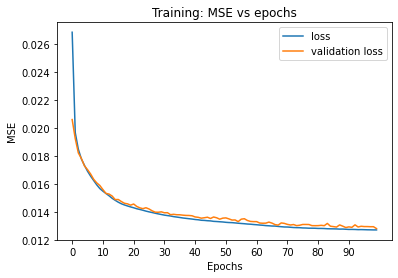

In [20]:
# compile model
fcnn_model.compile(optimizer = 'adam', 
                    loss     = 'mse', 
                    metrics  = ['mse'])

# fit model
start = time()
fit = fcnn_model.fit(x_train_f, x_train_f,
                    shuffle          = True, 
                    epochs           = 100, 
                    batch_size       = 100, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [21]:
# train/test predictions
train_pred = fcnn_model.predict(x_train_f).astype('float64').reshape(N,28,28)
test_pred  = fcnn_model.predict(x_test_f).astype('float64').reshape(M,28,28)

mse_train, ssim_train = image_mse(train_img, train_pred), image_ssim(train_img, train_pred)
mse_test, ssim_test   = image_mse(test_img, test_pred), image_ssim(test_img, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

313/313 [==============================] - 0s 1ms/step
Training - MSE: 0.013 | MSSIM: 0.892
Testing  - MSE: 0.012 | MSSIM: 0.892


1875/1875 [==============================] - 2s 816us/step
Latent Space dimension: (60000, 50)


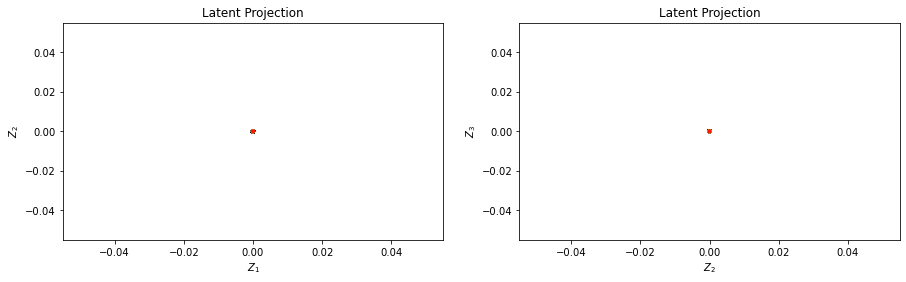

In [22]:
# latent space representation
fc_latent = fcnn_encoder.predict(x_train_f)
print('Latent Space dimension: {}'.format(fc_latent.shape))

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.scatter(fc_latent[:,0], fc_latent[:,1], c=cs, s=10)
plt.title('Latent Projection'); plt.xlabel('$Z_1$'); plt.ylabel('$Z_2$')
plt.subplot(122)
plt.scatter(fc_latent[:,1], fc_latent[:,2], c=cs, s=10)
plt.title('Latent Projection'); plt.xlabel('$Z_2$'); plt.ylabel('$Z_3$')
plt.show();

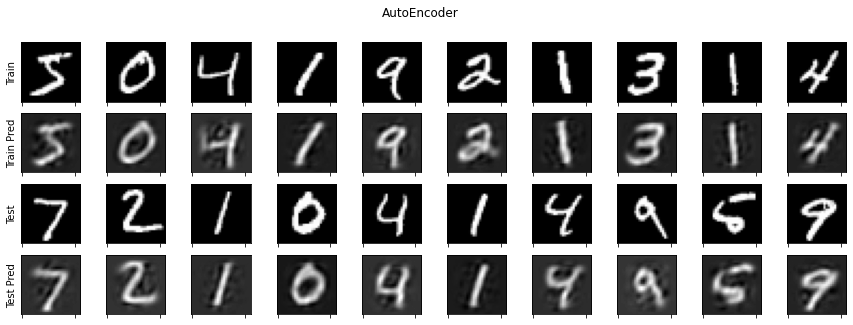

In [23]:
# visualize results
data = [train_img, train_pred, test_img, test_pred]
plot_results(data, 'AutoEncoder')

#### Convolutional AutoEncoder

In [24]:
keras.backend.clear_session()

inp = Input(shape=(28,28,1))
x = Conv2D(4, (3,3), padding='same', activation='relu')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)

shape_before_flatten = keras.backend.int_shape(x)[1:]
x = Flatten(name='latent_dim')(x)
enc = Dense(50)(x)
x = Dense(np.prod(shape_before_flatten))(enc)
x = Reshape(shape_before_flatten)(x)

x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(4, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

cnn_model = Model(inp,out)
cnn_encoder = Model(inp, enc)
print('Number of parameters: {:,}'.format(cnn_model.count_params()))

Number of parameters: 82,803


Training time: 11.77 minutes


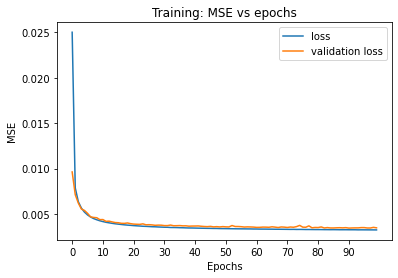

In [25]:
# compile model
cnn_model.compile(optimizer = 'adam',
                    loss     = 'mse', 
                    metrics  = ['mse'])

# fit model
start = time()
fit = cnn_model.fit(x_train, x_train,
                    shuffle          = True, 
                    epochs           = 100, 
                    batch_size       = 100, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [26]:
# train/test predictions
train_pred = cnn_model.predict(x_train).astype('float64').squeeze()
test_pred  = cnn_model.predict(x_test).astype('float64').squeeze()

mse_train, ssim_train = image_mse(train_img, train_pred), image_ssim(train_img, train_pred)
mse_test, ssim_test   = image_mse(test_img, test_pred), image_ssim(test_img, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

313/313 [==============================] - 1s 2ms/step
Training - MSE: 0.003 | MSSIM: 0.977
Testing  - MSE: 0.003 | MSSIM: 0.976


1875/1875 [==============================] - 2s 1ms/step
Latent Space dimension: (60000, 50)


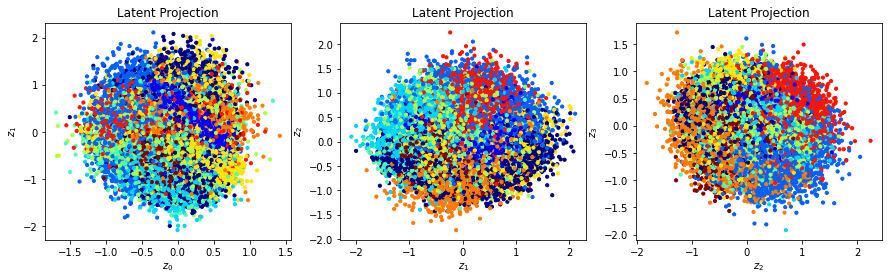

In [27]:
# latent space representation
cnn_latent = cnn_encoder.predict(x_train)
print('Latent Space dimension: {}'.format(cnn_latent.shape))

subs = 3
plt.figure(figsize=(15,4))
for i in range(subs):
    plt.subplot(1,subs,i+1)
    plt.scatter(cnn_latent[:,i], cnn_latent[:,i+1], c=cs, s=10)
    plt.title('Latent Projection')
    plt.xlabel('$z_{}$'.format(i)); plt.ylabel('$z_{}$'.format(i+1))
plt.show();

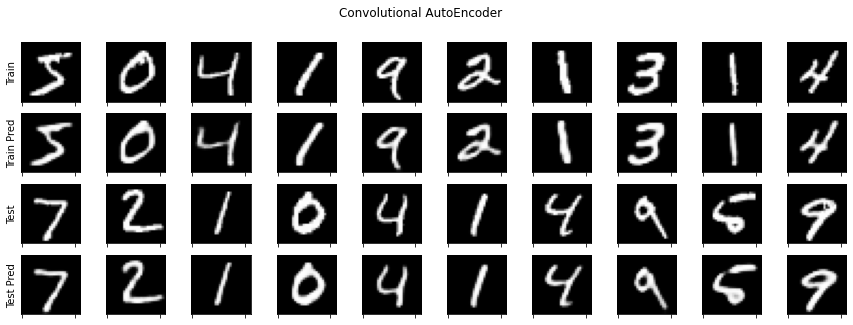

In [28]:
# visualize results
data = [train_img, train_pred, test_img, test_pred]
plot_results(data, 'Convolutional AutoEncoder')

#### Variational AutoEncoder

In [29]:
def sample(args):
    mean, sigma = args
    epsilon = keras.backend.random_normal(shape=(keras.backend.shape(mean)[0],2), mean=0.0, stddev=1.0)
    return mean + keras.backend.exp(sigma)*epsilon

In [30]:
keras.backend.clear_session()

# Encoder
inp = Input(shape=(28,28,1))
x = Conv2D(4, (3,3), padding='same', activation='relu')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
shape_before_flatten = keras.backend.int_shape(x)[1:]
x = Flatten(name='latent_dim')(x)
mean, sigma  = Dense(2)(x), Dense(2)(x)
enc = Lambda(sample)([mean, sigma])

# Decoder
z_inp = Input(shape=(2,))
x = Dense(50, activation='relu')(z_inp)
x = Dense(np.prod(shape_before_flatten), activation='relu')(x)
x = Reshape(shape_before_flatten)(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(4, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

# VAE
vae_encoder = Model(inp, enc)
vae_decoder = Model(z_inp, out)
vae_model   = Model(inp, vae_decoder(vae_encoder(inp)))
print('Number of parameters: {:,}'.format(vae_model.count_params()))

Number of parameters: 46,843


In [31]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

Training time: 3.92 minutes


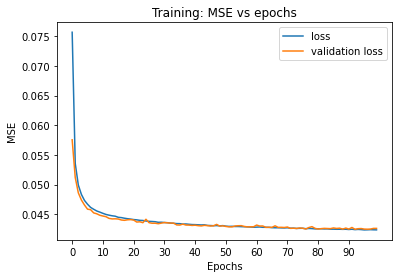

In [32]:
# compile model
keras.backend.clear_session()
vae_model.compile(optimizer = 'adam',
                    loss    = 'mse', 
                    metrics = ['mse'])

# fit model
start = time()
fit = vae_model.fit(x_train, x_train,
                    shuffle          = True, 
                    epochs           = 100, 
                    batch_size       = 100, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [33]:
# train/test predictions
train_pred = vae_model.predict(x_train).astype('float64').squeeze()
test_pred  = vae_model.predict(x_test).astype('float64').squeeze()

mse_train, ssim_train = image_mse(train_img, train_pred), image_ssim(train_img, train_pred)
mse_test, ssim_test   = image_mse(test_img, test_pred), image_ssim(test_img, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

313/313 [==============================] - 1s 3ms/step
Training - MSE: 0.042 | MSSIM: 0.592
Testing  - MSE: 0.043 | MSSIM: 0.589


1875/1875 [==============================] - 2s 1ms/step
Latent Space dimension: (60000, 2)


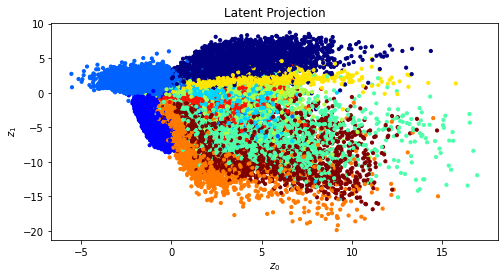

In [34]:
# latent space representation
vae_latent = vae_encoder.predict(x_train)
print('Latent Space dimension: {}'.format(vae_latent.shape))

subs = 1
plt.figure(figsize=(8,4))
for i in range(subs):
    plt.subplot(1,subs,i+1)
    plt.scatter(vae_latent[:,i], vae_latent[:,i+1], c=cs, s=10)
    plt.title('Latent Projection')
    plt.xlabel('$z_{}$'.format(i)); plt.ylabel('$z_{}$'.format(i+1))
plt.show();

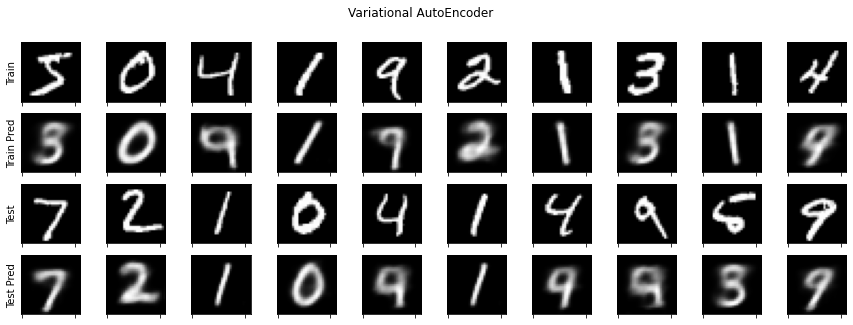

In [35]:
# visualize results
data = [train_img, train_pred, test_img, test_pred]
plot_results(data, 'Variational AutoEncoder')

***

**Subsurface Deep Learning:**

...

1/1 [==============================] - 0s 15ms/step


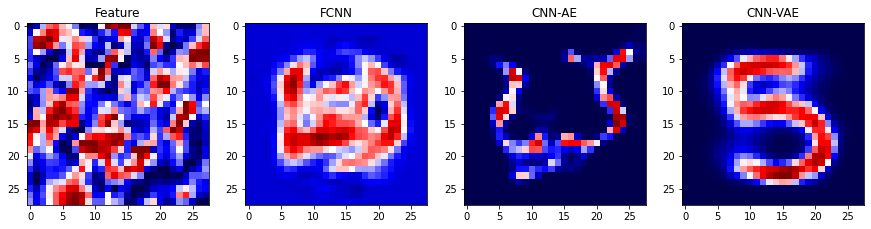

In [45]:
fcnn_ss = fcnn_model.predict(ZI_mm[feature_selected].reshape(1,784))
cnn_ss  = cnn_model.predict(np.expand_dims(np.expand_dims(ZI_mm[feature_selected], axis=-1), axis=0)).reshape(28,28)
vae_ss  = vae_model.predict(np.expand_dims(np.expand_dims(ZI_mm[feature_selected], axis=-1), axis=0)).reshape(28,28)

plt.figure(figsize=(15,4))
plt.subplot(141)
plt.imshow(ZI_mm[feature_selected], cmap='seismic'); plt.title('Feature')
plt.subplot(142)
plt.imshow(fcnn_ss.reshape(28,28), cmap='seismic'); plt.title('FCNN')
plt.subplot(143)
plt.imshow(cnn_ss, cmap='seismic'); plt.title('CNN-AE')
plt.subplot(144)
plt.imshow(vae_ss, cmap='seismic'); plt.title('CNN-VAE')
plt.show();

***

### Results and Discussion

Deep Learning:
- a

Important Notes:
- The MNIST dataset has the digits centered at the image. Therefore, we using the learned basis from this generic dataset, our subsurface image reconstructions will be most accurate near the center and quite bad near the edges. If we increase the dimension of the latent space, we start to gather information of the edges (which is irrelevant for MNIST but relevant for subsurface maps). Therefore, for this particular transfer learning problem, we might need to use more latent variables than desired. Using a different generic dataset with more information near the edges to learn the sparse encoding might help in transfer reconstruction.

MNIST:
- a

Subsurface:
- b

Conclusions:
- a

- MSE and SSIM provide useful measures for the goodness-of-fit and validity of our reconstructions. SSIM is especially useful when dealing with image datasets, and compares the mean and variance of a set of prior and posterior images. We see that for our experiment, MSE is low and SSIM is high when we try to reconstruct MNIST images from a latent dimension using MNIST basis, but we see medium MSE and SSIM (acceptable but not excellent) when reconstructing subsurface images from MNIST basis.

### References:
1. 
2. 
3. 

***

### About Me

I am currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, and I am supervised by Drs. Pyrcz and Torres-Verdin. My background is in Petroleum Engineering & Applied Mathematics from the University of Tulsa. I am originally from Venezuela!

At UT, I am working on the computational description of subsurface energy and environmental systems. I combine domain-specific knowledge with tools from machine learning & deep learning, math and statistics, for accurate characterization and forecasting of complex dynamical systems in the subsurface. My work is centered on integrated applied energy data analytics by developing novel technologies, practical workflows, demos and documentation to support the digital revolution in energy. My focus is on machine learning and data science applications for subsurface modeling and simulation, including: uncertainty quantification, inverse modeling, data assimilation, control & optimization, and physics-informed predictive analytics.


* More workflows to come on other advanced dimensionality reduction techniques!
    * PCA/kPCA, SVD, Dictionary Learning, tSNE, DFT/DCT/DWT, POD/DMD, Deep Learning-based AutoEncoders, ... 
* Also working on subsurface problems including machine learning & data science applications for reservoir modeling & simulation.
    * Uncertainty quantification, data assimilation, control & optimizaiton, inverse & reduced-order modeling! 

I hope this was helpful,

**Misael M. Morales**
#### [GitHub](https://github.com/misaelmmorales) | [Website](https://sites.google.com/view/misaelmmorales) | [LinkedIn](https://www.linkedin.com/in/misaelmmorales)

# END